### Ozone Object Instantiation

(0.0, 100.0)

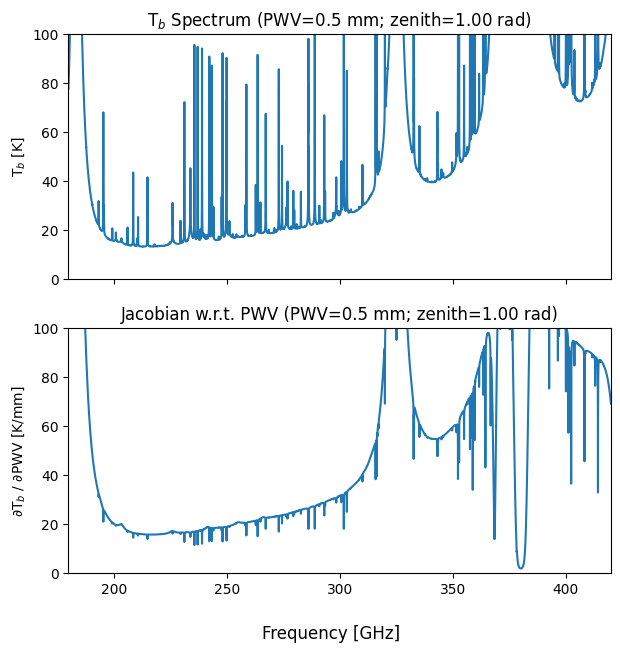

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

pwv = 0.5
zenith = 1

data_path = '/Users/namsonnguyen/repo/data/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
my_ozone = Ozone(am_model_data_path=data_path)
spectrum, pwv_jacobian, __ = my_ozone(pwv, zenith, return_pwv_jacobian=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True, sharey=True)

freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])
ax1.set_title(r"T$_b$ Spectrum" + f" (PWV={pwv} mm; zenith={zenith:.2f} rad)")
ax1.plot(freq_channels, spectrum[0,0])
ax1.set_ylabel(r'T$_b$ [K]')
ax1.set_xlim(min(freq_channels), max(freq_channels));

ax2.plot(freq_channels, pwv_jacobian)
ax2.set_title(f"Jacobian w.r.t. PWV (PWV={pwv} mm; zenith={zenith:.2f} rad)")
ax2.set_ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
fig.supxlabel('Frequency [GHz]')
ax2.set_xlim(min(freq_channels), max(freq_channels));
ax2.set_ylim(0, 100)

In [5]:
%%timeit
my_ozone = Ozone(am_model_data_path=data_path)

769 ms ± 89.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit
# post efficiency change
my_ozone = Ozone(am_model_data_path=data_path)

837 ms ± 84.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit
spectrum, pwv_jacobian, __ = my_ozone(pwv, zenith)

184 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
# post efficiency change
spectrum, pwv_jacobian, __ = my_ozone(pwv, zenith, return_pwv_jacobian=True)

166 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
# post efficiency change
spectrum, __, __ = my_ozone(pwv, zenith)

145 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
# post efficiency change
__, pwv_jacobian, __ = my_ozone(pwv, zenith, return_pwv_jacobian=True, return_model_spectrum=False)

21.3 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
# post efficiency change
__, __, zenith_jacobian = my_ozone(pwv, zenith, return_zenith_jacobian=True, return_model_spectrum=False)

20.6 ms ± 483 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


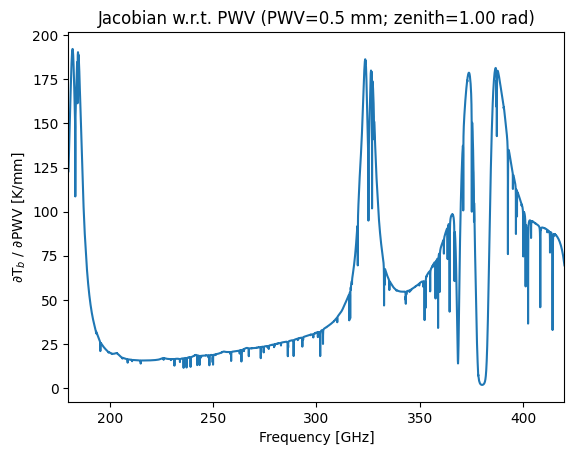

In [9]:
plt.plot(freq_channels, pwv_jacobian)
plt.title(f"Jacobian w.r.t. PWV (PWV={pwv} mm; zenith={zenith:.2f} rad)")
plt.ylabel(r'$\partial$T$_b$ / $\partial$PWV [K/mm]')
plt.xlabel('Frequency [GHz]')
plt.xlim(min(freq_channels), max(freq_channels));

### Nscale Regular Grid Interpolator

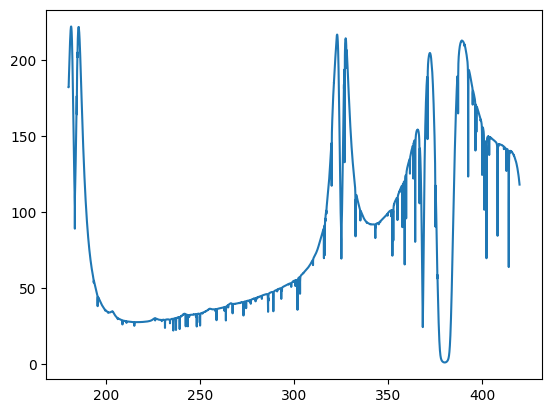

In [10]:
from scipy.interpolate import RegularGridInterpolator

interp_func = RegularGridInterpolator(
    points=(my_ozone.data['Nscale']['map'], my_ozone.data['airmass']['map'], my_ozone.data['freq']['map']), 
    values=my_ozone.data['Nscale']['jacobian'], method="linear"
)

nominal_pwv = my_ozone._extract_nominal_pwv()
pwv = 1
nscale = np.log10(pwv / nominal_pwv)

zenith = np.radians(45)
airmass = my_ozone._zenith_to_airmass(zenith)

x,y,z = np.meshgrid(nscale, airmass, my_ozone.data['freq']['map'], indexing='ij')

spectrum = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)[0,0]
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

plt.plot(freq_channels, spectrum)


### Airmass Regular Grid Interpolator

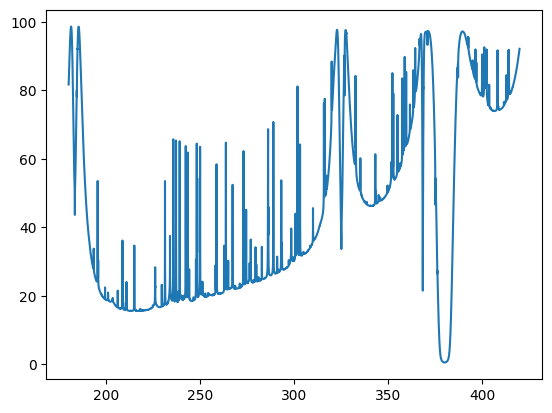

In [11]:
from scipy.interpolate import RegularGridInterpolator

interp_func = RegularGridInterpolator(
    points=(my_ozone.data['Nscale']['map'], my_ozone.data['airmass']['map'], my_ozone.data['freq']['map']), 
    values=my_ozone.data['airmass']['jacobian'], method="linear"
)

nominal_pwv = my_ozone._extract_nominal_pwv()
pwv = 1
nscale = np.log10(pwv / nominal_pwv)

zenith = np.radians(45)
airmass = my_ozone._zenith_to_airmass(zenith)

x,y,z = np.meshgrid(nscale, airmass, my_ozone.data['freq']['map'], indexing='ij')

spectrum = interp_func((x.flatten(),y.flatten(),z.flatten())).reshape(x.shape)[0,0]

normalization_factor = (1/np.cos(zenith))*np.tan(zenith)
spectrum = spectrum * normalization_factor

freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

plt.plot(freq_channels, spectrum)

### AM-run script

In [7]:
import tools
import numpy as np

ZA = None
NSCALE = None
AM = None
print(f"Starting am for AM={AM:.2f} (ZA={np.degrees(ZA):.1f} deg); NSCALE={NSCALE:.2f}")
freq_start = 210
freq_end = 240
filepath="test.sh"
script = f"""
/home/gkeating/repo/am-14.0/bin/am MaunaKea_SON_50.amc \
    {freq_start} GHz {freq_end} GHz 1 MHz {ZA} rad 277 K {NSCALE} \
    > newdata/MaunaKea_Tb_Spectrum_{AM:.2f}_{NSCALE:.2f}.out \
    2> newdata/MaunaKea_Tb_Spectrum_{AM:.2f}_{NSCALE:.2f}.err
"""
tools.run(filepath, script)

/Users/namsonnguyen/repo/ozone_modeling
